In [1]:
from enum import Enum, auto

class TaskType(Enum):
    Regression = auto()
    Classification = auto()

class Fun(Enum):
    Sigmoid = auto()
    ReLU = auto()
    Tanh = auto()
    Linear = auto()

class LossFun(Enum):
    MSE = auto()


In [2]:
import numpy as np

np.random.seed(42)


class MLP:
    def __init__(self, layer_sizes, task_type: TaskType):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.task_type = task_type

        self.weights = []
        self.biases = []
        for i in range(self.num_layers - 1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1]))
            W = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i + 1]))
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(W)
            self.biases.append(b)

    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def _sigmoid_derivative(x):
        s = MLP._sigmoid(x)
        return s * (1 - s)

    @staticmethod
    def _relu(x):
        return np.maximum(0, x)

    @staticmethod
    def _relu_derivative(x):
        return (x > 0).astype(float)

    @staticmethod
    def _tanh(x):
        return np.tanh(x)

    @staticmethod
    def _tanh_derivative(x):
        return 1 - np.tanh(x) ** 2

    @staticmethod
    def _linear(x):
        return x

    @staticmethod
    def _linear_derivative(x):
        return np.ones_like(x)

    @staticmethod
    def _get_activation(name: Fun):
        if name == Fun.Sigmoid:
            return MLP._sigmoid, MLP._sigmoid_derivative
        elif name == Fun.ReLU:
            return MLP._relu, MLP._relu_derivative
        elif name == Fun.Tanh:
            return MLP._tanh, MLP._tanh_derivative
        elif name == Fun.Linear:
            return MLP._linear, MLP._linear_derivative
        else:
            raise ValueError(f"Nieznana funkcja aktywacji: {name}")

    @staticmethod
    def _mse(y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    @staticmethod
    def _mse_derivative(y_true, y_pred):
        return y_pred - y_true

    @staticmethod
    def _get_loss(name: LossFun):
        if name == LossFun.MSE:
            return MLP._mse, MLP._mse_derivative
        else:
            raise ValueError(f"Nieznana funkcja straty: {name}")

    def forward(self, X, activation_fun: Fun):
        activation_func, _ = self._get_activation(activation_fun)

        if self.task_type == TaskType.Regression:
            output_activation_func, _ = self._get_activation(Fun.Linear)
        else:
            output_activation_func, _ = self._get_activation(Fun.Sigmoid)

        activations = [X]
        zs = []

        A = X
        for i in range(self.num_layers - 2):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = activation_func(Z)
            zs.append(Z)
            activations.append(A)

        Z_out = np.dot(A, self.weights[-1]) + self.biases[-1]
        A_out = output_activation_func(Z_out)

        zs.append(Z_out)
        activations.append(A_out)

        return A_out, activations, zs

    def backward(
        self, X, y, y_pred, activations, zs, activation_fun: Fun, loss_fun: LossFun
    ):
        _, activation_derivative = self._get_activation(activation_fun)
        _, loss_derivative = self._get_loss(loss_fun)

        if self.task_type == TaskType.Regression:
            _, output_activation_derivative = self._get_activation(Fun.Linear)
        else:
            _, output_activation_derivative = self._get_activation(Fun.Sigmoid)

        gradients_w = [np.zeros_like(w) for w in self.weights]
        gradients_b = [np.zeros_like(b) for b in self.biases]

        num_samples = X.shape[0]

        delta = loss_derivative(y, y_pred) * output_activation_derivative(zs[-1])

        gradients_w[-1] = np.dot(activations[-2].T, delta) / num_samples
        gradients_b[-1] = np.sum(delta, axis=0, keepdims=True) / num_samples

        for l in range(2, self.num_layers):
            delta = np.dot(delta, self.weights[-l + 1].T) * activation_derivative(
                zs[-l]
            )

            gradients_w[-l] = np.dot(activations[-l - 1].T, delta) / num_samples
            gradients_b[-l] = np.sum(delta, axis=0, keepdims=True) / num_samples

        return gradients_w, gradients_b

    def update_weights(self, gradients_w, gradients_b, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * gradients_w[i]
            self.biases[i] -= learning_rate * gradients_b[i]

    def train(
        self,
        X,
        y,
        epochs,
        learning_rate,
        activation_fun: Fun,
        loss_fun: LossFun = LossFun.MSE,
    ):
        loss_func, _ = self._get_loss(loss_fun)
        error_history = []

        for epoch in range(epochs):
            y_pred, activations, zs = self.forward(X, activation_fun)
            error = loss_func(y, y_pred)
            error_history.append(error)

            gradients_w, gradients_b = self.backward(
                X, y, y_pred, activations, zs, activation_fun, loss_fun
            )

            self.update_weights(gradients_w, gradients_b, learning_rate)

            if (epoch + 1) % (epochs // 10) == 0:
                print(f"Epoka {epoch + 1}/{epochs}, Błąd: {error:.6f}")

        return error_history

    def predict(self, X, activation_fun: Fun):
        y_pred, _, _ = self.forward(X, activation_fun)
        return y_pred

Epoka 1000/10000, Błąd: 0.178966
Epoka 2000/10000, Błąd: 0.086075
Epoka 3000/10000, Błąd: 0.051945
Epoka 4000/10000, Błąd: 0.037964
Epoka 5000/10000, Błąd: 0.030252
Epoka 6000/10000, Błąd: 0.025300
Epoka 7000/10000, Błąd: 0.021847
Epoka 8000/10000, Błąd: 0.019304
Epoka 9000/10000, Błąd: 0.017350
Epoka 10000/10000, Błąd: 0.015800


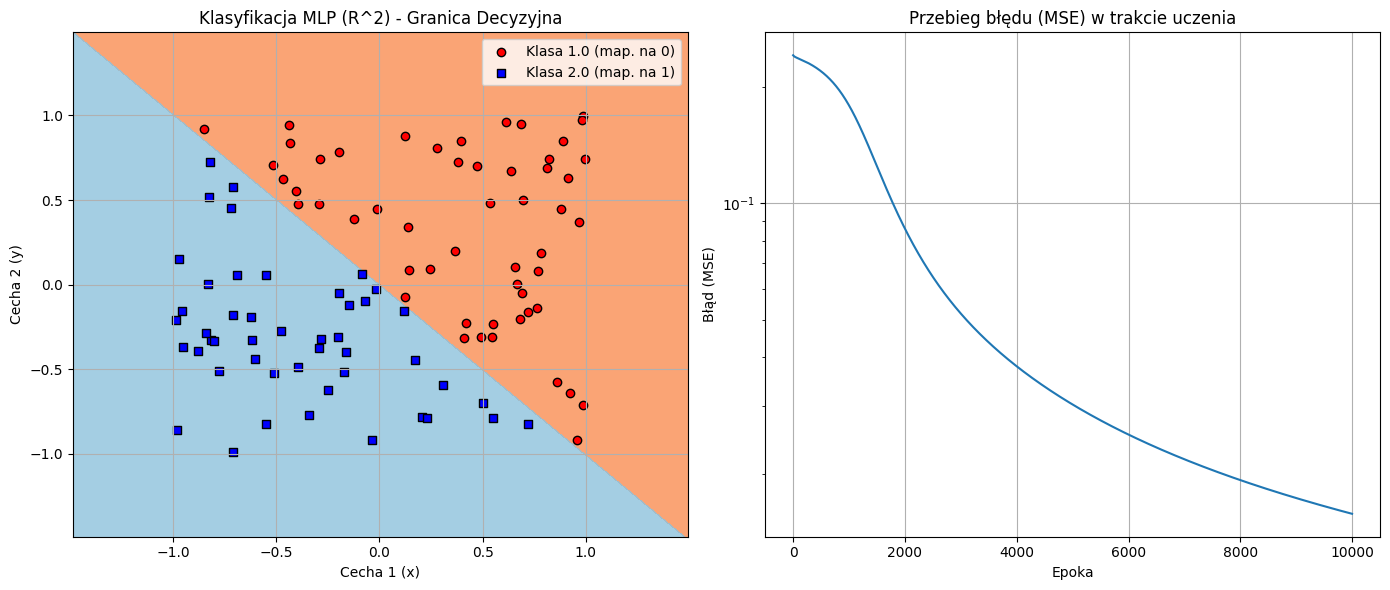

In [3]:
import numpy as np
import matplotlib.pyplot as plt

nazwa_pliku = 'data/Classification/data.simple.train.100.csv'

data = np.loadtxt(nazwa_pliku, delimiter=',', skiprows=1)

X_dane = data[:, 0:2]
y_dane_surowe = data[:, 2]

unique_classes = np.unique(y_dane_surowe)

class_map = {unique_classes[0]: 0, unique_classes[1]: 1}
y_dane = np.array([class_map[y] for y in y_dane_surowe]).reshape(-1, 1)

mlp_model = MLP(layer_sizes=[2, 10, 10, 1], task_type=TaskType.Classification)

error_history = mlp_model.train(X_dane, y_dane, 
                                epochs=10000, 
                                learning_rate=0.1, 
                                activation_fun=Fun.Sigmoid, 
                                loss_fun=LossFun.MSE)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

h = .02
x_min, x_max = X_dane[:, 0].min() - 0.5, X_dane[:, 0].max() + 0.5
y_min, y_max = X_dane[:, 1].min() - 0.5, X_dane[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = mlp_model.predict(np.c_[xx.ravel(), yy.ravel()], activation_fun=Fun.Sigmoid)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 3), cmap=plt.cm.RdYlBu, alpha=0.8)

label_0 = f"Klasa {unique_classes[0]} (map. na 0)"
label_1 = f"Klasa {unique_classes[1]} (map. na 1)"

plt.scatter(X_dane[y_dane.ravel() == 0, 0], X_dane[y_dane.ravel() == 0, 1], 
            c='red', marker='o', edgecolors='k', label=label_0)
plt.scatter(X_dane[y_dane.ravel() == 1, 0], X_dane[y_dane.ravel() == 1, 1], 
            c='blue', marker='s', edgecolors='k', label=label_1)

plt.title('Klasyfikacja MLP (R^2) - Granica Decyzyjna')
plt.xlabel('Cecha 1 (x)')
plt.ylabel('Cecha 2 (y)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(error_history)
plt.title('Przebieg błędu (MSE) w trakcie uczenia')
plt.xlabel('Epoka')
plt.ylabel('Błąd (MSE)')
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()

Epoka 1000/10000, Błąd: 1857.430545
Epoka 2000/10000, Błąd: 1526.517556
Epoka 3000/10000, Błąd: 1177.006131
Epoka 4000/10000, Błąd: 996.787452
Epoka 5000/10000, Błąd: 888.281997
Epoka 6000/10000, Błąd: 736.726997
Epoka 7000/10000, Błąd: 692.288399
Epoka 8000/10000, Błąd: 654.639123
Epoka 9000/10000, Błąd: 742.257730
Epoka 10000/10000, Błąd: 642.150447


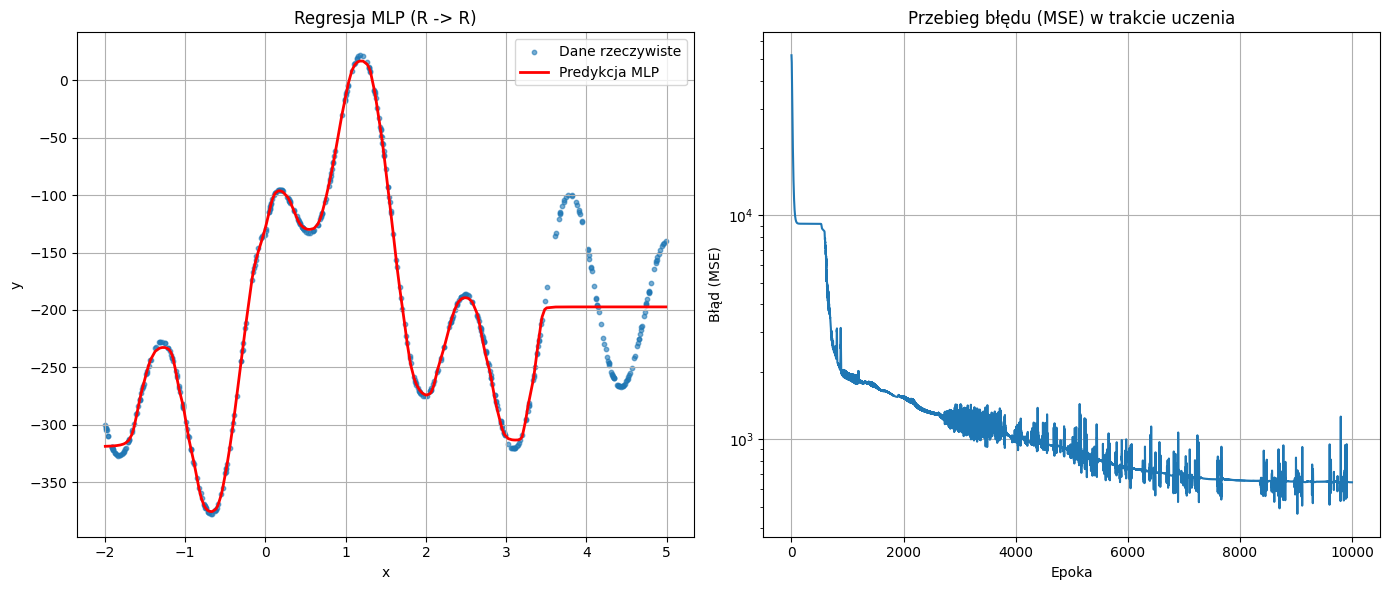

In [6]:
import numpy as np
import matplotlib.pyplot as plt

nazwa_pliku = 'data/Regression/data.multimodal.train.500.csv'

data = np.loadtxt(nazwa_pliku, delimiter=',', skiprows=1)

X_dane = data[:, 0].reshape(-1, 1)

y_dane = data[:, 1].reshape(-1, 1)

mlp_reg = MLP(layer_sizes=[1, 32, 32, 1], task_type=TaskType.Regression)

error_history = mlp_reg.train(X_dane, y_dane,
                              epochs=10000,
                              learning_rate=0.001,
                              activation_fun=Fun.Tanh,
                              loss_fun=LossFun.MSE)

y_pred = mlp_reg.predict(X_dane, activation_fun=Fun.Tanh)

sort_indices = np.argsort(X_dane.ravel())
X_dane_sorted = X_dane[sort_indices]
y_pred_sorted = y_pred[sort_indices]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_dane, y_dane, label='Dane rzeczywiste', alpha=0.6, s=10)
plt.plot(X_dane_sorted, y_pred_sorted, color='red', linewidth=2, label='Predykcja MLP')
plt.title('Regresja MLP (R -> R)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(error_history)
plt.title('Przebieg błędu (MSE) w trakcie uczenia')
plt.xlabel('Epoka')
plt.ylabel('Błąd (MSE)')
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()